In [1]:
## USE for Multi GPU Systems
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics

from collections import Counter

target_names = ["Knuckle", "Finger"]

tf.__version__

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


'1.13.1'

In [2]:
df = pd.read_pickle("DataStudyEvaluation/df_statistics.pkl")

lst = df.userID.unique()
df["GestureId"] = df.TaskID % 17

#df_train = dfAll[dfAll.userID.isin(train_ids)]
#df_test = dfAll[dfAll.userID.isin(test_ids)]

x = np.concatenate(df.Blobs.values).reshape(-1,27,15,1)
x = x / 255.0

# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(df.TaskID.unique())
y = tf.keras.utils.to_categorical(df.TaskID, num_classes)

labels = sorted(df.TaskID.unique())

In [3]:
x = np.stack(df.Blobs)
x = x.reshape(-1, 27, 15, 1)

In [4]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y = tf.keras.utils.to_categorical(df.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: [1. 0.]')

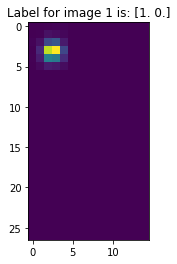

In [5]:
i = 1
plt.imshow(x[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y[i]))

In [6]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [7]:
loadpath = "./ModelSnapshots/CNN-33767.h5"
model = tf.keras.models.load_model(loadpath)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [8]:
%%time
lst = []
batch = 100
for i in range(0, len(x), batch):
    _x = x[i: i+batch]
    lst.extend(model.predict(_x))

CPU times: user 16 s, sys: 1.39 s, total: 17.4 s
Wall time: 12.5 s


In [9]:
df["InputMethodPred"] = lst
df.InputMethodPred = df.InputMethodPred.apply(lambda x: np.argmax(x))

In [10]:
df = df.groupby(["userID", "TaskID", "VersionID"])[["InputMethodPred", "InputMethod"]].agg(lambda x: x.tolist()).reset_index()

In [11]:
df.InputMethod = df.InputMethod.apply(lambda x: Counter(x).most_common()[0][0])
df.InputMethodPred = df.InputMethodPred.apply(lambda x: Counter(x).most_common()[0][0])

In [12]:
df.groupby(["InputMethod", "InputMethodPred"]).count()

userID  TaskID  VersionID
InputMethod InputMethodPred                           
0           0                  1882    1882       1882
            1                   102     102        102
1           0                    28      28         28
            1                  2499    2499       2499

In [13]:
print(sklearn.metrics.confusion_matrix(df.InputMethod.values, df.InputMethodPred.values, labels=[0, 1]))
cm = sklearn.metrics.confusion_matrix(df.InputMethod.values, df.InputMethodPred.values, labels=[0, 1], )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
print("Accuray: %.3f" % sklearn.metrics.accuracy_score(df.InputMethod.values, df.InputMethodPred.values))
print("Recall: %.3f" % metrics.recall_score(df.InputMethod.values, df.InputMethodPred.values, average="macro"))
print("Precision: %.3f" % metrics.average_precision_score(df.InputMethod.values, df.InputMethodPred.values, average="macro"))
print("F1-Score: %.3f" % metrics.f1_score(df.InputMethod.values, df.InputMethodPred.values, average="macro"))
print(sklearn.metrics.classification_report(df.InputMethod.values, df.InputMethodPred.values, target_names=target_names))

[[1882  102]
 [  28 2499]]
[[0.94858871 0.05141129]
 [0.01108033 0.98891967]]
Accuray: 0.971
Recall: 0.969
Precision: 0.956
F1-Score: 0.971
              precision    recall  f1-score   support

     Knuckle       0.99      0.95      0.97      1984
      Finger       0.96      0.99      0.97      2527

    accuracy                           0.97      4511
   macro avg       0.97      0.97      0.97      4511
weighted avg       0.97      0.97      0.97      4511

